# 📝 Insult Detection with Word2Vec Embeddings

In this notebook, we will build a binary classification pipeline to detect insults in comments using Word2Vec embeddings. We'll apply:
- Logistic Regression
- Random Forest
- XGBoost

## 🚀 Goal
Detect whether a comment contains an insult (1) or not (0).


## 📦 Step 1: Install & Load Packages

In [60]:
!pip install gensim kagglehub

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

import kagglehub


In [ ]:
#!pip install --upgrade pandas scikit-learn

## 📥 Step 2: Load and Inspect the Dataset


In [37]:
# Dataset: Jigsaw Toxic Comment Classification (we'll use the insult label) from kaggle

# https://github.com/tianqwang/Toxic-Comment-Classification-Challenge
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
test_y = pd.read_csv("/content/test_labels.csv")

In [47]:
print(train.shape)
print(test.shape)

(159571, 9)
(153164, 3)


In [38]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [39]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [40]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


## 🧹 Step 3: Preprocessing for Word2Vec



In [45]:
# We'll use Gensim's `simple_preprocess` to tokenize and clean the text.

import nltk
from nltk.corpus import stopwords
import string

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define additional preprocessing
def preprocess_text(text):
    # Tokenize and clean using simple_preprocess
    tokens = simple_preprocess(text, deacc=True, min_len=2, max_len=15)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

# Apply preprocessing to all comments
train['tokens'] = train['comment_text'].apply(preprocess_text)
test['tokens'] = test['comment_text'].apply(preprocess_text)

# Prepare labeled sentences for Word2Vec (all comments together)
sentences = train['tokens'].tolist() + test['tokens'].tolist()

print("Sample preprocessed tokens:")
print(train['tokens'].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sample preprocessed tokens:
0    [explanation, edits, made, username, hardcore,...
1    [aww, matches, background, colour, seemingly, ...
2    [hey, man, really, trying, edit, war, guy, con...
3    [make, real, suggestions, improvement, wondere...
4                  [sir, hero, chance, remember, page]
Name: tokens, dtype: object


## 🧠 Step 4: Train Word2Vec Embedding

In [46]:
# We'll train Word2Vec embeddings on the entire corpus.

import time

# Set parameters
EMBEDDING_DIM = 100  # Size of each word vector
WINDOW_SIZE = 3      # Context window size
MIN_COUNT = 5        # Ignores words with frequency lower than this
WORKERS = 4          # Number of CPU cores
SG = 1               # Skip-gram (1) or CBOW (0)
EPOCHS = 10          # Number of training iterations

print("Training Word2Vec model...")
start_time = time.time()

# Initialize and train the model
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=WORKERS,
    sg=SG,
    epochs=EPOCHS
)

print(f"Training completed in {time.time()-start_time:.2f} seconds")
print(f"Vocabulary size: {len(w2v_model.wv)}")

# Test the embeddings
print("\nSample word similarities:")
print("bad -> awful:", w2v_model.wv.similarity('bad', 'awful'))
print("idiot -> stupid:", w2v_model.wv.similarity('idiot', 'stupid'))
print("love -> hate:", w2v_model.wv.similarity('love', 'hate'))

# Save the model
w2v_model.save("word2vec_insult_detection.model")

Training Word2Vec model...
Training completed in 533.96 seconds
Vocabulary size: 64219

Sample word similarities:
bad -> awful: 0.56910646
idiot -> stupid: 0.6843937
love -> hate: 0.5092969


## 🧬 Step 5: Vectorize Comments using Word2Vec


In [50]:
# Convert each comment to the average of its word vectors
# Convert to final feature and label arrays

from tqdm import tqdm

def vectorize_comments(word2vec_model, tokenized_comments):
    """Vectorize all comments more efficiently"""
    vectors = []
    vocab = set(word2vec_model.wv.key_to_index)

    for comment in tqdm(tokenized_comments):
        # Filter words in vocabulary
        words = [word for word in comment if word in vocab]
        if words:
            vectors.append(np.mean(word2vec_model.wv[words], axis=0))
        else:
            vectors.append(np.zeros(word2vec_model.vector_size))

    return np.array(vectors)

# Vectorize with progress bar
X_train = vectorize_comments(w2v_model, train['tokens'].tolist())
X_test = vectorize_comments(w2v_model, test['tokens'].tolist())

# Get target labels
y_train = train['insult'].values

print("Shape of training vectors:", X_train.shape)
print("Shape of test vectors:", X_test.shape)

Shape of training vectors: (159571, 100)
Shape of test vectors: (153164, 100)


In [49]:
#Handling Empty Documents

empty_train = np.sum(np.all(X_train == 0, axis=1))
empty_test = np.sum(np.all(X_test == 0, axis=1))

print(f"{empty_train} training comments became empty vectors")
print(f"{empty_test} test comments became empty vectors")

# Option: Replace zero vectors with small random values if many empty
if empty_train > 0:
    print("Warning: Some comments resulted in zero vectors")

127 training comments became empty vectors
886 test comments became empty vectors


In [51]:
# Train/Test split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

## 🤖 Step 6: Train Models

In [63]:
def evaluate_model(model, name):
    model.fit(X_train_final, y_train_final)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"\n🔍 {name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    return model


🚀 Training Logistic Regression

🔍 Logistic Regression Accuracy: 0.9206
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     30340
           1       0.37      0.89      0.53      1575

    accuracy                           0.92     31915
   macro avg       0.68      0.91      0.74     31915
weighted avg       0.96      0.92      0.94     31915



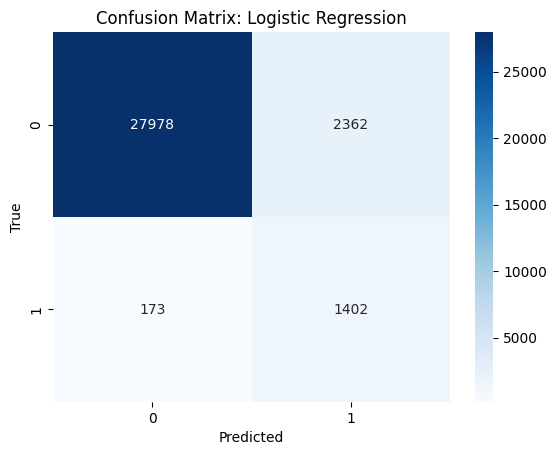

In [64]:
# Logistic Regression
print("="*50)
print("🚀 Training Logistic Regression")
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='liblinear'
)
lr_model = evaluate_model(lr_model, "Logistic Regression")

🌲 Training Random Forest

🔍 Random Forest Accuracy: 0.9506
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     30340
           1       0.50      0.79      0.61      1575

    accuracy                           0.95     31915
   macro avg       0.74      0.88      0.79     31915
weighted avg       0.96      0.95      0.96     31915



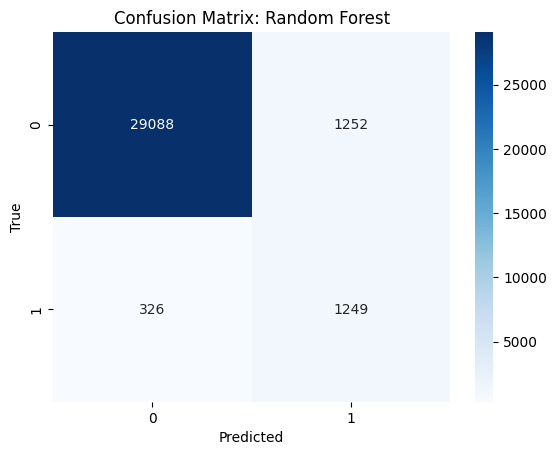

In [66]:
# Random Forest
print("="*50)
print("🌲 Training Random Forest")
rf_model = RandomForestClassifier(
    class_weight='balanced_subsample',
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model = evaluate_model(rf_model, "Random Forest")

⚡ Training XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 XGBoost Accuracy: 0.9695
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     30340
           1       0.75      0.57      0.65      1575

    accuracy                           0.97     31915
   macro avg       0.86      0.78      0.82     31915
weighted avg       0.97      0.97      0.97     31915



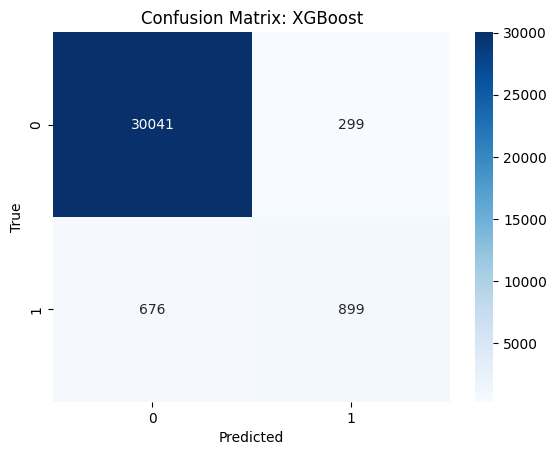

In [65]:
# XGBoost

print("="*50)
print("⚡ Training XGBoost")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model = evaluate_model(xgb_model, "XGBoost")

In [67]:
# Compare model performances
print("="*50)
print("🏆 Model Comparison Summary")
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

comparison = []
for name, model in models.items():
    y_pred = model.predict(X_val)
    comparison.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'F1 Score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    })

pd.DataFrame(comparison).set_index('Model').style.background_gradient(cmap='Blues')

🏆 Model Comparison Summary


,Accuracy,F1 Score,ROC AUC
Model,,,
Logistic Regression,0.920570,0.525192,0.965730
Random Forest,0.950556,0.612856,0.962537
XGBoost,0.969450,0.648395,0.969286


## 📌 Summary

- You learned how to use Word2Vec embeddings for **insult detection**
- Built a custom vectorizer by averaging word vectors
- Trained Logistic Regression, Random Forest, and XGBoost on the resulting features

### 🔍 Next Steps
- Try pre-trained Word2Vec (e.g. Google News vectors)
- Use TF-IDF weighting for word embeddings
- Try deep learning models (LSTM, BERT, etc.)

🎉 Great job on completing this project!